Preprocessing Steps For Chasing the Trends: Run Rate, Powerplay, and Death Over Analysis in IPL Using Big Data

In [ ]:
!pip -q install pyspark==3.5.1
from pyspark.sql import SparkSession, functions as F, types as T

spark = SparkSession.builder.appName("IPL-BigData").getOrCreate()
spark


In [ ]:
matches = spark.read.csv("matches_2008-2024.csv", header=True, inferSchema=True)
deliveries = spark.read.csv("deliveries_2008-2024.csv", header=True, inferSchema=True)

print("matches rows:", matches.count(), "deliveries rows:", deliveries.count())
matches.printSchema()
deliveries.printSchema()


matches rows: 1095 deliveries rows: 260920
root
 |-- id: integer (nullable = true)
 |-- season: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- date: date (nullable = true)
 |-- match_type: string (nullable = true)
 |-- player_of_match: string (nullable = true)
 |-- venue: string (nullable = true)
 |-- team1: string (nullable = true)
 |-- team2: string (nullable = true)
 |-- toss_winner: string (nullable = true)
 |-- toss_decision: string (nullable = true)
 |-- winner: string (nullable = true)
 |-- result: string (nullable = true)
 |-- result_margin: string (nullable = true)
 |-- target_runs: string (nullable = true)
 |-- target_overs: string (nullable = true)
 |-- super_over: string (nullable = true)
 |-- method: string (nullable = true)
 |-- umpire1: string (nullable = true)
 |-- umpire2: string (nullable = true)

root
 |-- match_id : double (nullable = true)
 |-- inning : double (nullable = true)
 |-- batting_team                : string (nullable = true)
 |-- bow

In [ ]:
d = deliveries.join(
    matches.select(
        F.col("id").alias("match_id2"),
        "season", "date", "venue", "city", "winner"
    ),
    deliveries["match_id "] == F.col("match_id2"),
    "left"
).drop("match_id2")

In [ ]:
print(deliveries.columns)


['match_id ', 'inning ', 'batting_team                ', 'bowling_team                ', 'over ', 'ball ', 'batter                  ', 'bowler                  ', 'non_striker             ', 'batsman_runs ', 'extra_runs ', 'total_runs ', 'extras_type ', 'is_wicket ', 'player_dismissed        ', 'dismissal_kind        ', 'fielder']


In [ ]:
# Clean column names: remove leading/trailing spaces
deliveries = deliveries.toDF(*[c.strip() for c in deliveries.columns])

print(deliveries.columns)  # confirm cleaned names


['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball', 'batter', 'bowler', 'non_striker', 'batsman_runs', 'extra_runs', 'total_runs', 'extras_type', 'is_wicket', 'player_dismissed', 'dismissal_kind', 'fielder']


In [ ]:
from pyspark.sql import functions as F

# Clean column names (important, removes spaces!)
deliveries = deliveries.toDF(*[c.strip() for c in deliveries.columns])

# Phase classification
d = deliveries.withColumn(
    "phase",
    F.when((F.col("over") >= 1) & (F.col("over") <= 6), "Powerplay")
     .when((F.col("over") >= 7) & (F.col("over") <= 15), "Middle")
     .when((F.col("over") >= 16) & (F.col("over") <= 20), "Death")
)

# Legal balls (exclude extras - only balls with extra_runs = 0 are legal)
legal_ball = (F.col("extra_runs") == 0)
d = d.withColumn("legal_ball", F.when(legal_ball, 1).otherwise(0))

# Wickets (if player_dismissed is not null)
d = d.withColumn("is_wicket", F.when(F.col("player_dismissed").isNotNull(), 1).otherwise(0))

# Show sample rows
d.select("match_id", "over", "ball", "phase", "legal_ball", "is_wicket").show(10)

d.select("match_id", "over", "ball", "phase", "legal_ball", "is_wicket").show(10)


+--------+----+----+---------+----------+---------+
|match_id|over|ball|    phase|legal_ball|is_wicket|
+--------+----+----+---------+----------+---------+
|335982.0| 0.0| 1.0|     NULL|         0|        1|
|335982.0| 0.0| 2.0|     NULL|         1|        1|
|335982.0| 0.0| 3.0|     NULL|         0|        1|
|335982.0| 0.0| 4.0|     NULL|         1|        1|
|335982.0| 0.0| 5.0|     NULL|         1|        1|
|335982.0| 0.0| 6.0|     NULL|         1|        1|
|335982.0| 0.0| 7.0|     NULL|         0|        1|
|335982.0| 1.0| 1.0|Powerplay|         1|        1|
|335982.0| 1.0| 2.0|Powerplay|         1|        1|
|335982.0| 1.0| 3.0|Powerplay|         1|        1|
+--------+----+----+---------+----------+---------+
only showing top 10 rows

+--------+----+----+---------+----------+---------+
|match_id|over|ball|    phase|legal_ball|is_wicket|
+--------+----+----+---------+----------+---------+
|335982.0| 0.0| 1.0|     NULL|         0|        1|
|335982.0| 0.0| 2.0|     NULL|        

In [ ]:
# Step 4: Aggregations - Batting Performance by Phase
phase_summary = (
    d.groupBy("match_id", "phase")
     .agg(
         F.sum("total_runs").alias("runs"),
         F.sum("legal_ball").alias("balls"),
         F.sum("is_wicket").alias("wickets")
     )
     .withColumn("run_rate", (F.col("runs") * 6 / F.col("balls")))
)

# Show results
phase_summary.show(20, truncate=False)


+--------+---------+-----+-----+-------+------------------+
|match_id|phase    |runs |balls|wickets|run_rate          |
+--------+---------+-----+-----+-------+------------------+
|336026.0|Middle   |105.0|107  |109    |5.88785046728972  |
|392196.0|Death    |83.0 |43   |47     |11.581395348837209|
|392219.0|Death    |50.0 |31   |32     |9.67741935483871  |
|548306.0|Middle   |94.0 |106  |111    |5.320754716981132 |
|598038.0|Death    |81.0 |47   |48     |10.340425531914894|
|729299.0|Death    |62.0 |45   |51     |8.266666666666667 |
|734039.0|Powerplay|94.0 |69   |75     |8.173913043478262 |
|829719.0|Death    |71.0 |29   |36     |14.689655172413794|
|829793.0|Death    |80.0 |46   |49     |10.434782608695652|
|829807.0|Middle   |46.0 |24   |24     |11.5              |
|980985.0|NULL     |6.0  |12   |12     |3.0               |
|336021.0|Middle   |38.0 |48   |51     |4.75              |
|336032.0|Powerplay|113.0|72   |76     |9.416666666666666 |
|392195.0|Middle   |113.0|107  |110    |

In [ ]:
# Join with matches dataset to add team and venue info
df_with_matches = phase_summary.join(
    matches.select("id", "venue", "team1", "team2"),
    phase_summary.match_id == matches.id,
    "left"
)

df_with_matches.select("match_id", "venue", "phase", "runs", "balls", "run_rate", "wickets").show(20, truncate=False)


+--------+----------------------------------------------------+---------+-----+-----+------------------+-------+
|match_id|venue                                               |phase    |runs |balls|run_rate          |wickets|
+--------+----------------------------------------------------+---------+-----+-----+------------------+-------+
|336026.0|M Chinnaswamy Stadium                               |Middle   |105.0|107  |5.88785046728972  |109    |
|392196.0|Kingsmead                                           |Death    |83.0 |43   |11.581395348837209|47     |
|392219.0|New Wanderers Stadium                               |Death    |50.0 |31   |9.67741935483871  |32     |
|548306.0|MA Chidambaram Stadium, Chepauk                     |Middle   |94.0 |106  |5.320754716981132 |111    |
|598038.0|Subrata Roy Sahara Stadium                          |Death    |81.0 |47   |10.340425531914894|48     |
|729299.0|Sharjah Cricket Stadium                             |Death    |62.0 |45   |8.266666666

In [ ]:
# Venue-wise summary: Runs, Balls, Wickets, Run Rate by Phase
venue_summary = (
    df_with_matches.groupBy("venue", "phase")
        .agg(
            F.sum("runs").alias("total_runs"),
            F.sum("balls").alias("total_balls"),
            F.sum("wickets").alias("total_wickets")
        )
        .withColumn("run_rate", (F.col("total_runs") * 6 / F.col("total_balls")))
        .orderBy("venue", "phase")
)

venue_summary.show(50, truncate=False)


+---------------------------------------------------------------------+---------+----------+-----------+-------------+------------------+
|venue                                                                |phase    |total_runs|total_balls|total_wickets|run_rate          |
+---------------------------------------------------------------------+---------+----------+-----------+-------------+------------------+
|Arun Jaitley Stadium                                                 |NULL     |190.0     |175        |184          |6.514285714285714 |
|Arun Jaitley Stadium                                                 |Death    |986.0     |561        |609          |10.545454545454545|
|Arun Jaitley Stadium                                                 |Middle   |1934.0    |1475       |1536         |7.867118644067797 |
|Arun Jaitley Stadium                                                 |Powerplay|1433.0    |994        |1027         |8.64989939637827  |
|Arun Jaitley Stadium, Delhi      

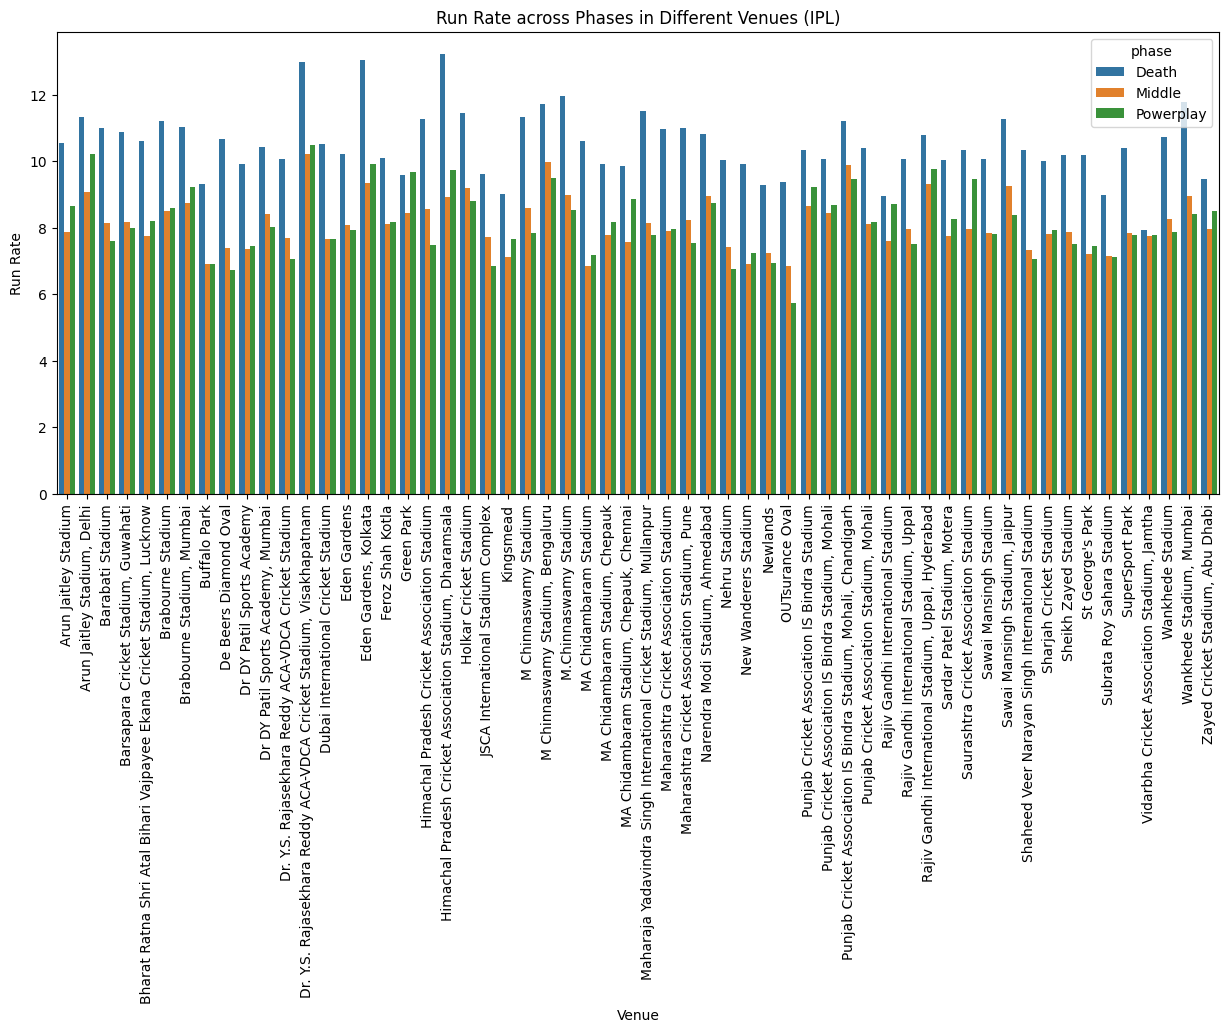

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas for visualization
venue_pdf = venue_summary.toPandas()

# Plot Run Rate comparison across phases for each venue
plt.figure(figsize=(15, 6))
sns.barplot(data=venue_pdf, x="venue", y="run_rate", hue="phase")
plt.xticks(rotation=90)
plt.title("Run Rate across Phases in Different Venues (IPL)")
plt.ylabel("Run Rate")
plt.xlabel("Venue")
plt.show()


In [ ]:
from pyspark.sql.functions import to_date, month

# Convert date to proper format
matches = matches.withColumn("match_date", to_date("date"))

# Extract month to estimate climate/season
matches = matches.withColumn("month", month("match_date"))

matches.select("id", "city", "venue", "match_date", "month").show(10, truncate=False)


+------+----------+------------------------------------------+----------+-----+
|id    |city      |venue                                     |match_date|month|
+------+----------+------------------------------------------+----------+-----+
|335982|Bangalore |M Chinnaswamy Stadium                     |2008-04-18|4    |
|335983|Chandigarh|Punjab Cricket Association Stadium, Mohali|2008-04-19|4    |
|335984|Delhi     |Feroz Shah Kotla                          |2008-04-19|4    |
|335985|Mumbai    |Wankhede Stadium                          |2008-04-20|4    |
|335986|Kolkata   |Eden Gardens                              |2008-04-20|4    |
|335987|Jaipur    |Sawai Mansingh Stadium                    |2008-04-21|4    |
|335988|Hyderabad |Rajiv Gandhi International Stadium, Uppal |2008-04-22|4    |
|335989|Chennai   |MA Chidambaram Stadium, Chepauk           |2008-04-23|4    |
|335990|Hyderabad |Rajiv Gandhi International Stadium, Uppal |2008-04-24|4    |
|335991|Chandigarh|Punjab Cricket Associ

In [ ]:
df_climate = phase_summary.join(matches, phase_summary.match_id == matches.id, "left") \
              .select("match_id", "venue", "city", "month", "phase",
                      "runs", "balls", "wickets")

In [ ]:
climate_summary = (
    df_climate.groupBy("city", "month", "phase")
        .agg(
            F.sum("runs").alias("total_runs"),
            F.sum("balls").alias("total_balls"),
            F.sum("wickets").alias("total_wickets")
        )
        .withColumn("run_rate", (F.col("total_runs") * 6 / F.col("total_balls")))
        .orderBy("city", "month", "phase")
)

climate_summary.show(50, truncate=False)


+---------+-----+---------+----------+-----------+-------------+------------------+
|city     |month|phase    |total_runs|total_balls|total_wickets|run_rate          |
+---------+-----+---------+----------+-----------+-------------+------------------+
|Abu Dhabi|4    |NULL     |99.0      |95         |101          |6.252631578947368 |
|Abu Dhabi|4    |Death    |369.0     |237        |254          |9.341772151898734 |
|Abu Dhabi|4    |Middle   |922.0     |717        |741          |7.7154811715481175|
|Abu Dhabi|4    |Powerplay|543.0     |494        |528          |6.5951417004048585|
|Abu Dhabi|9    |NULL     |119.0     |108        |111          |6.611111111111111 |
|Abu Dhabi|9    |Death    |553.0     |342        |381          |9.701754385964913 |
|Abu Dhabi|9    |Middle   |1180.0    |919        |959          |7.704026115342764 |
|Abu Dhabi|9    |Powerplay|803.0     |643        |672          |7.493001555209953 |
|Abu Dhabi|10   |NULL     |202.0     |207        |217          |5.8550724637

In [ ]:
df_climate = df_climate.withColumn(
    "dew_factor",
    F.when((F.col("month").isin([9,10,11])), "High Dew")
     .when((F.col("month").isin([3,4,5])), "Low Dew")
     .otherwise("Moderate Dew")
)

dew_summary = (
    df_climate.groupBy("dew_factor", "phase")
        .agg(
            F.sum("runs").alias("total_runs"),
            F.sum("balls").alias("total_balls"),
            F.sum("wickets").alias("total_wickets")
        )
        .withColumn("run_rate", (F.col("total_runs") * 6 / F.col("total_balls")))
        .orderBy("dew_factor", "phase")
)

dew_summary.show(50, truncate=False)


+------------+---------+----------+-----------+-------------+------------------+
|dew_factor  |phase    |total_runs|total_balls|total_wickets|run_rate          |
+------------+---------+----------+-----------+-------------+------------------+
|High Dew    |NULL     |1175.0    |1124       |1182         |6.272241992882562 |
|High Dew    |Death    |6373.0    |3712       |3994         |10.301185344827585|
|High Dew    |Middle   |12471.0   |9555       |9988         |7.831083202511774 |
|High Dew    |Powerplay|8520.0    |6462       |6773         |7.910863509749303 |
|Low Dew     |NULL     |12449.0   |11846      |12699        |6.305419550903259 |
|Low Dew     |Death    |68866.0   |39276      |42489        |10.520317751298503|
|Low Dew     |Middle   |141462.0  |103808     |108768       |8.176364056720098 |
|Low Dew     |Powerplay|95714.0   |70546      |74532        |8.140560768860034 |
|Moderate Dew|NULL     |27.0      |23         |25           |7.043478260869565 |
|Moderate Dew|Death    |173.

In [ ]:
from pyspark.sql import functions as F

# (safety) trim any stray spaces in column names
deliveries = deliveries.toDF(*[c.strip() for c in deliveries.columns])
matches    = matches.toDF(*[c.strip() for c in matches.columns])

# --- Step 3 recap (must already exist); recreate quickly in case runtime reset ---
d = deliveries.withColumn(
    "phase",
    F.when((F.col("over") >= 1) & (F.col("over") <= 6), "Powerplay")
     .when((F.col("over") >= 7) & (F.col("over") <= 15), "Middle")
     .when((F.col("over") >= 16) & (F.col("over") <= 20), "Death")
)
d = d.withColumn("legal_ball", F.when(F.col("extra_runs") == 0, 1).otherwise(0))
d = d.withColumn("is_wicket", F.when(F.col("player_dismissed").isNotNull(), 1).otherwise(0))

# Aggregate to match/inning/phase/team level
match_phase = (
    d.groupBy("match_id","inning","phase","batting_team","bowling_team")
     .agg(
        F.sum("total_runs").alias("runs"),
        F.sum("legal_ball").alias("balls"),
        F.sum("is_wicket").alias("wickets")
     )
     .withColumn("run_rate", (F.col("runs")*6.0)/F.col("balls"))
)

# Join match metadata (season, date, venue, city)
match_phase = match_phase.join(
    matches.select(
        F.col("id").alias("match_id2"),
        "season","date","venue","city"
    ),
    on=(match_phase.match_id == F.col("match_id2")),
    how="left"
).drop("match_id2")

match_phase.cache()
match_phase.show(10, truncate=False)


+--------+------+---------+----------------------------+----------------------------+----+-----+-------+------------------+------+----------+---------------------------------------------------+--------------+
|match_id|inning|phase    |batting_team                |bowling_team                |runs|balls|wickets|run_rate          |season|date      |venue                                              |city          |
+--------+------+---------+----------------------------+----------------------------+----+-----+-------+------------------+------+----------+---------------------------------------------------+--------------+
|336003.0|2.0   |Powerplay|Kolkata Knight Riders       |Kings XI Punjab             |25.0|36   |37     |4.166666666666667 |2008  |2008-05-03|Punjab Cricket Association Stadium, Mohali         |Chandigarh    |
|336024.0|1.0   |Death    |Mumbai Indians              |Deccan Chargers             |50.0|22   |29     |13.636363636363637|2008  |2008-05-18|Rajiv Gandhi Internatio

In [ ]:
# League-level per phase
league_phase = (
    match_phase.groupBy("phase")
      .agg(F.sum("runs").alias("runs"), F.sum("balls").alias("balls"))
      .withColumn("run_rate", (F.col("runs")*6.0)/F.col("balls"))
      .orderBy("phase")
)
league_phase.show(truncate=False)

# Team ranking in each phase (all seasons combined)
team_phase = (
    match_phase.groupBy("batting_team","phase")
      .agg(F.sum("runs").alias("runs"), F.sum("balls").alias("balls"))
      .withColumn("run_rate", (F.col("runs")*6.0)/F.col("balls"))
      .orderBy("phase", F.desc("run_rate"))
)
team_phase.show(50, truncate=False)


+---------+--------+------+------------------+
|phase    |runs    |balls |run_rate          |
+---------+--------+------+------------------+
|NULL     |13651.0 |12993 |6.303855922419764 |
|Death    |75412.0 |43077 |10.503795528936555|
|Middle   |154288.0|113576|8.150736071000916 |
|Powerplay|104405.0|77149 |8.119742316815513 |
+---------+--------+------+------------------+

+----------------------------+------+-------+-----+------------------+
|batting_team                |phase |runs   |balls|run_rate          |
+----------------------------+------+-------+-----+------------------+
|Royal Challengers Bengaluru |NULL  |124.0  |88   |8.454545454545455 |
|Kochi Tuskers Kerala        |NULL  |103.0  |78   |7.923076923076923 |
|Delhi Capitals              |NULL  |652.0  |552  |7.086956521739131 |
|Kolkata Knight Riders       |NULL  |1720.0 |1483 |6.958867161159811 |
|Gujarat Lions               |NULL  |209.0  |181  |6.928176795580111 |
|Deccan Chargers             |NULL  |482.0  |437  |6.61

In [ ]:
venue_phase = (
    match_phase.groupBy("venue","phase")
      .agg(
          F.sum("runs").alias("total_runs"),
          F.sum("balls").alias("total_balls"),
          F.sum("wickets").alias("total_wickets")
      )
      .withColumn("run_rate", (F.col("total_runs")*6.0)/F.col("total_balls"))
      .orderBy("venue","phase")
)
venue_phase.show(60, truncate=False)


+---------------------------------------------------------------------+---------+----------+-----------+-------------+------------------+
|venue                                                                |phase    |total_runs|total_balls|total_wickets|run_rate          |
+---------------------------------------------------------------------+---------+----------+-----------+-------------+------------------+
|Arun Jaitley Stadium                                                 |NULL     |190.0     |175        |184          |6.514285714285714 |
|Arun Jaitley Stadium                                                 |Death    |986.0     |561        |609          |10.545454545454545|
|Arun Jaitley Stadium                                                 |Middle   |1934.0    |1475       |1536         |7.867118644067797 |
|Arun Jaitley Stadium                                                 |Powerplay|1433.0    |994        |1027         |8.64989939637827  |
|Arun Jaitley Stadium, Delhi      

In [ ]:
over_trend = (
    d.join(matches, d.match_id == matches.id, "left")
     .groupBy("season","over")
     .agg(F.sum("total_runs").alias("runs"), F.sum("legal_ball").alias("balls"))
     .withColumn("run_rate", (F.col("runs")*6.0)/F.col("balls"))
     .orderBy("season","over")
)
over_trend.show(20, truncate=False)

+------+----+------+-----+------------------+
|season|over|runs  |balls|run_rate          |
+------+----+------+-----+------------------+
|2008  |0.0 |703.0 |677  |6.2304283604135895|
|2008  |1.0 |923.0 |677  |8.180206794682423 |
|2008  |2.0 |826.0 |681  |7.277533039647577 |
|2008  |3.0 |912.0 |673  |8.13075780089153  |
|2008  |4.0 |1017.0|689  |8.856313497822931 |
|2008  |5.0 |977.0 |678  |8.646017699115044 |
|2008  |6.0 |828.0 |672  |7.392857142857143 |
|2008  |7.0 |852.0 |671  |7.618479880774963 |
|2008  |8.0 |844.0 |657  |7.707762557077626 |
|2008  |9.0 |856.0 |659  |7.793626707132018 |
|2008  |10.0|934.0 |667  |8.401799100449775 |
|2008  |11.0|957.0 |651  |8.820276497695852 |
|2008  |12.0|878.0 |655  |8.042748091603054 |
|2008  |13.0|956.0 |645  |8.893023255813954 |
|2008  |14.0|968.0 |636  |9.132075471698114 |
|2008  |15.0|903.0 |603  |8.985074626865671 |
|2008  |16.0|940.0 |563  |10.017761989342807|
|2008  |17.0|930.0 |538  |10.371747211895912|
|2008  |18.0|913.0 |504  |10.86904

MATCH columns: ['id', 'season', 'city', 'date', 'match_type', 'player_of_match', 'venue', 'team1', 'team2', 'toss_winner', 'toss_decision', 'winner', 'result', 'result_margin', 'target_runs', 'target_overs', 'super_over', 'method', 'umpire1', 'umpire2']
DELIVERIES columns: ['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball', 'batter', 'bowler', 'non_striker', 'batsman_runs', 'extra_runs', 'total_runs', 'extras_type', 'is_wicket', 'player_dismissed', 'dismissal_kind', 'fielder']

Sample rr_by_inning:
+------------------------------------------------+---------+------+------+-----+------------------+
|venue                                           |phase    |inning|runs  |balls|run_rate          |
+------------------------------------------------+---------+------+------+-----+------------------+
|MA Chidambaram Stadium, Chepauk                 |Powerplay|2.0   |2353.0|1692 |8.343971631205674 |
|Vidarbha Cricket Association Stadium, Jamtha    |Death    |2.0   |96.0  |63 

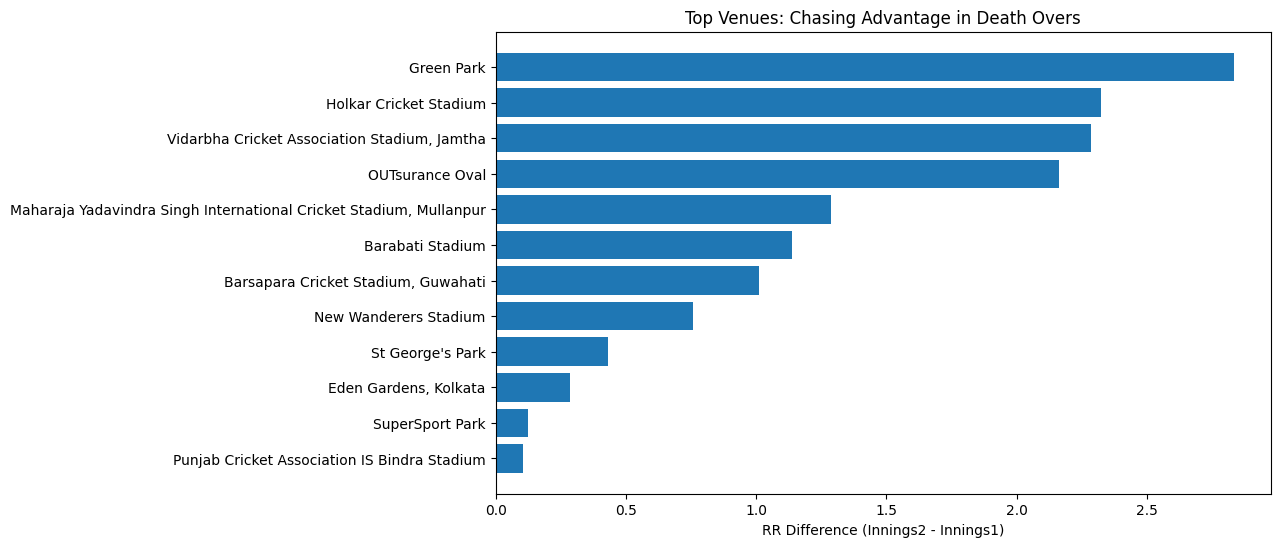


Done. If this errors, copy the printed column lists above and the exact error text here.


In [ ]:
# Paste this entire cell and run it
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1) Read CSVs (adjust paths if yours are different)
matches = spark.read.csv("matches_2008-2024.csv", header=True, inferSchema=True)
deliveries = spark.read.csv("deliveries_2008-2024.csv", header=True, inferSchema=True)

# 2) Normalize column names (trim, lowercase, replace spaces -> underscores)
def normalize_cols(df):
    new_cols = [c.strip().lower().replace(' ', '_') for c in df.columns]
    return df.toDF(*new_cols)

matches = normalize_cols(matches)
deliveries = normalize_cols(deliveries)

print("MATCH columns:", matches.columns)
print("DELIVERIES columns:", deliveries.columns)

# 3) Determine expression for total_runs (some datasets have total_runs, some don't)
if "total_runs" in deliveries.columns:
    total_runs_expr = F.col("total_runs")
else:
    # fallback to batsman_runs + extra_runs if total_runs missing
    # use coalesce to avoid nulls
    total_runs_expr = (F.coalesce(F.col("batsman_runs"), F.lit(0)) +
                       F.coalesce(F.col("extra_runs"), F.lit(0)))

# 4) Build 'd' DataFrame and safe derived columns
# Ensure 'over' and 'inning' exist
assert "over" in deliveries.columns, "Column 'over' not found in deliveries (check your CSV headers)"
assert "inning" in deliveries.columns, "Column 'inning' not found in deliveries"

d = deliveries.withColumn(
    "phase",
    F.when((F.col("over") >= 1) & (F.col("over") <= 6), "Powerplay")
     .when((F.col("over") >= 7) & (F.col("over") <= 15), "Middle")
     .when((F.col("over") >= 16) & (F.col("over") <= 20), "Death")
     .otherwise("Other")
)

# legal_ball: if extra_runs column exists, treat extra_runs==0 as legal; otherwise assume legal
if "extra_runs" in deliveries.columns:
    legal_cond = (F.col("extra_runs") == 0)
else:
    legal_cond = F.lit(True)

d = d.withColumn("legal_ball", F.when(legal_cond, 1).otherwise(0))

# is_wicket if player_dismissed exists
if "player_dismissed" in deliveries.columns:
    d = d.withColumn("is_wicket", F.when(F.col("player_dismissed").isNotNull(), 1).otherwise(0))
else:
    d = d.withColumn("is_wicket", F.lit(0))

# Join d with matches *before* aggregation
d_with_matches = d.join(matches.select("id", "season", "venue", "city"),
                         d.match_id == matches.id,
                         "left").drop("id")

# 5) Compute run-rate per venue, phase, inning (avoid pivot)
rr_by_inning = (
    d_with_matches.groupBy("venue", "phase", "inning")
     .agg(
         F.sum(total_runs_expr).alias("runs"),
         F.sum("legal_ball").alias("balls")
     )
     .filter(F.col("balls") > 0)                       # avoid divide-by-zero
     .withColumn("run_rate", (F.col("runs") * 6.0) / F.col("balls"))
)

print("\nSample rr_by_inning:")
rr_by_inning.show(15, truncate=False)

# 6) Split inning=1 and inning=2 then join (stable approach)
inn1 = rr_by_inning.filter(F.col("inning") == 1).select("venue", "phase", F.col("run_rate").alias("rr_inn1"))
inn2 = rr_by_inning.filter(F.col("inning") == 2).select("venue", "phase", F.col("run_rate").alias("rr_inn2"))

dew_innings_diff = (
    inn1.join(inn2, ["venue", "phase"], how="outer")
         .withColumn("diff_inn2_minus_inn1",
                     F.when(F.col("rr_inn1").isNotNull() & F.col("rr_inn2").isNotNull(),
                            F.col("rr_inn2") - F.col("rr_inn1")
                     ).otherwise(None))
         .orderBy(F.desc("diff_inn2_minus_inn1"))
)

print("\nColumns in dew_innings_diff:", dew_innings_diff.columns)
print("\nTop dew_innings_diff rows:")
dew_innings_diff.show(60, truncate=False)

# 7) Plot top Death-phase venues by diff (if available)
try:
    pdf = dew_innings_diff.filter(F.col("phase") == "Death").orderBy(F.desc("diff_inn2_minus_inn1")).limit(12).toPandas()
    if not pdf.empty:
        plt.figure(figsize=(10,6))
        plt.barh(pdf["venue"], pdf["diff_inn2_minus_inn1"])
        plt.gca().invert_yaxis()
        plt.xlabel("RR Difference (Innings2 - Innings1)")
        plt.title("Top Venues: Chasing Advantage in Death Overs")
        plt.show()
    else:
        print("No 'Death' phase rows found in dew_innings_diff (check phase assignment).")
except Exception as e:
    print("Plotting failed:", e)

print("\nDone. If this errors, copy the printed column lists above and the exact error text here.")

In [ ]:
# Step 9: Categorize venues into Dew Impact bins
dew_summary = (
    dew_innings_diff
      .groupBy("phase")
      .agg(
          F.avg("diff_inn2_minus_inn1").alias("avg_diff"),
          F.count("*").alias("venues_count")
      )
)

print("\nAverage dew impact (Innings2 - Innings1) by phase:")
dew_summary.show(truncate=False)

# Categorize bins: High (>6), Moderate (3–6), Low (<3)
dew_bins = (
    dew_innings_diff
      .withColumn(
          "dew_factor",
          F.when(F.col("diff_inn2_minus_inn1") > 6, "High Dew")
           .when((F.col("diff_inn2_minus_inn1") >= 3) & (F.col("diff_inn2_minus_inn1") <= 6), "Moderate Dew")
           .when(F.col("diff_inn2_minus_inn1") < 3, "Low Dew")
           .otherwise("No Dew")
      )
      .groupBy("dew_factor", "phase")
      .agg(
          F.count("*").alias("venues"),
          F.avg("diff_inn2_minus_inn1").alias("avg_diff")
      )
      .orderBy("phase", "dew_factor")
)

print("\nVenues grouped by Dew Factor bins:")
dew_bins.show(truncate=False)



Average dew impact (Innings2 - Innings1) by phase:
+---------+---------------------+------------+
|phase    |avg_diff             |venues_count|
+---------+---------------------+------------+
|Middle   |-0.007925600785570211|58          |
|Death    |-0.7943848890715112  |58          |
|Other    |0.2351239938756926   |58          |
|Powerplay|0.13084253243591842  |58          |
+---------+---------------------+------------+


Venues grouped by Dew Factor bins:
+------------+---------+------+---------------------+
|dew_factor  |phase    |venues|avg_diff             |
+------------+---------+------+---------------------+
|Low Dew     |Death    |58    |-0.7943848890715112  |
|Low Dew     |Middle   |58    |-0.007925600785570211|
|Low Dew     |Other    |56    |0.10417766958691377  |
|Moderate Dew|Other    |2     |3.901621073961499    |
|Low Dew     |Powerplay|58    |0.13084253243591842  |
+------------+---------+------+---------------------+



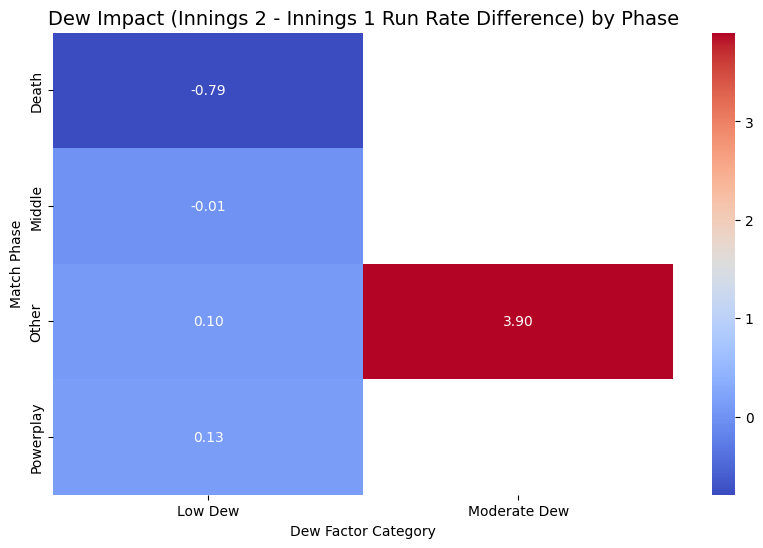

In [ ]:
# Step 10: Visualize Dew Factor by Phase
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert Spark DataFrame to Pandas for plotting
dew_bins_pd = dew_bins.toPandas()

plt.figure(figsize=(10,6))
pivot_table = dew_bins_pd.pivot(index="phase", columns="dew_factor", values="avg_diff")

sns.heatmap(pivot_table, annot=True, cmap="coolwarm", fmt=".2f")

plt.title("Dew Impact (Innings 2 - Innings 1 Run Rate Difference) by Phase", fontsize=14)
plt.ylabel("Match Phase")
plt.xlabel("Dew Factor Category")
plt.show()


In [ ]:
# Step 11: Venue-wise Dew Impact (Innings 2 - Innings 1 Run Rate Difference)

venue_dew = (
    match_phase.groupBy("venue")
    .agg(
        F.avg(F.when(F.col("inning")==2, F.col("runs")).otherwise(None)).alias("avg_runs_inn2"),
        F.avg(F.when(F.col("inning")==1, F.col("runs")).otherwise(None)).alias("avg_runs_inn1"),
        F.count("match_id").alias("matches")
    )
    .withColumn("dew_impact", F.col("avg_runs_inn2") - F.col("avg_runs_inn1"))
    .orderBy(F.desc("dew_impact"))
)

venue_dew.show(20, truncate=False)

+------------------------------------------------------------------+------------------+------------------+-------+--------------------+
|venue                                                             |avg_runs_inn2     |avg_runs_inn1     |matches|dew_impact          |
+------------------------------------------------------------------+------------------+------------------+-------+--------------------+
|Holkar Cricket Stadium                                            |44.65625          |41.22857142857143 |67     |3.4276785714285722  |
|Green Park                                                        |43.53333333333333 |40.3125           |31     |3.2208333333333314  |
|Saurashtra Cricket Association Stadium                            |42.81578947368421 |42.225            |80     |0.590789473684211   |
|Zayed Cricket Stadium, Abu Dhabi                                  |40.1              |39.75             |62     |0.3500000000000014  |
|Maharaja Yadavindra Singh International Cricket

In [ ]:
# Step 12: Team-wise Dew Impact

team_dew = (
    d.groupBy("batting_team", "inning")
     .agg(F.sum(total_runs_expr).alias("runs"),
          F.countDistinct("match_id").alias("matches"))
)

# Pivot to separate Innings 1 and Innings 2 runs per team
team_dew_pivot = (
    team_dew.groupBy("batting_team")
     .pivot("inning", [1,2])
     .agg(F.avg("runs"))
     .withColumnRenamed("1", "avg_runs_inn1")
     .withColumnRenamed("2", "avg_runs_inn2")
)

# Calculate dew impact = difference between innings
team_dew_pivot = team_dew_pivot.withColumn(
    "dew_impact",
    F.col("avg_runs_inn2") - F.col("avg_runs_inn1")
).orderBy(F.desc("dew_impact"))

team_dew_pivot.show(truncate=False)


+----------------------------+-------------+-------------+----------+
|batting_team                |avg_runs_inn1|avg_runs_inn2|dew_impact|
+----------------------------+-------------+-------------+----------+
|Delhi Daredevils            |11247.0      |13038.0      |1791.0    |
|Rajasthan Royals            |16860.0      |17852.0      |992.0     |
|Delhi Capitals              |7056.0       |7823.0       |767.0     |
|Pune Warriors               |2973.0       |3385.0       |412.0     |
|Gujarat Lions               |2267.0       |2589.0       |322.0     |
|Gujarat Titans              |3755.0       |4002.0       |247.0     |
|Kochi Tuskers Kerala        |1009.0       |892.0        |-117.0    |
|Kolkata Knight Riders       |19713.0      |19582.0      |-131.0    |
|Rising Pune Supergiant      |1304.0       |1166.0       |-138.0    |
|Rising Pune Supergiants     |1123.0       |940.0        |-183.0    |
|Royal Challengers Bengaluru |1758.0       |1172.0       |-586.0    |
|Lucknow Super Giant

+------+------------------+-----------------+--------------------+
|season|rr_inn1           |rr_inn2          |dew_impact          |
+------+------------------+-----------------+--------------------+
|2008  |8.455245283018868 |8.616797462013691|0.16155217899482288 |
|2009  |7.7406235878897425|7.530344715973459|-0.2102788719162838 |
|2010  |8.440808195788275 |8.168334849863513|-0.27247334592476236|
|2011  |7.965862974456911 |7.817378880374075|-0.14848409408283647|
|2012  |8.111794039197495 |7.858529483135161|-0.25326455606233367|
|2013  |8.032542372881355 |7.611579072250564|-0.4209633006307918 |
|2014  |8.430848772081    |8.35495193041355 |-0.07589684166744881|
|2015  |8.713947290494522 |8.324597102392968|-0.3893501881015542 |
|2016  |8.32896983494593  |8.602739726027398|0.2737698910814679  |
|2017  |8.523747276688454 |8.640922929017785|0.11717565232933147 |
|2018  |8.86211818441336  |8.691129643669447|-0.17098854074391312|
|2019  |8.603124552099755 |8.47504509921828 |-0.12807945288147

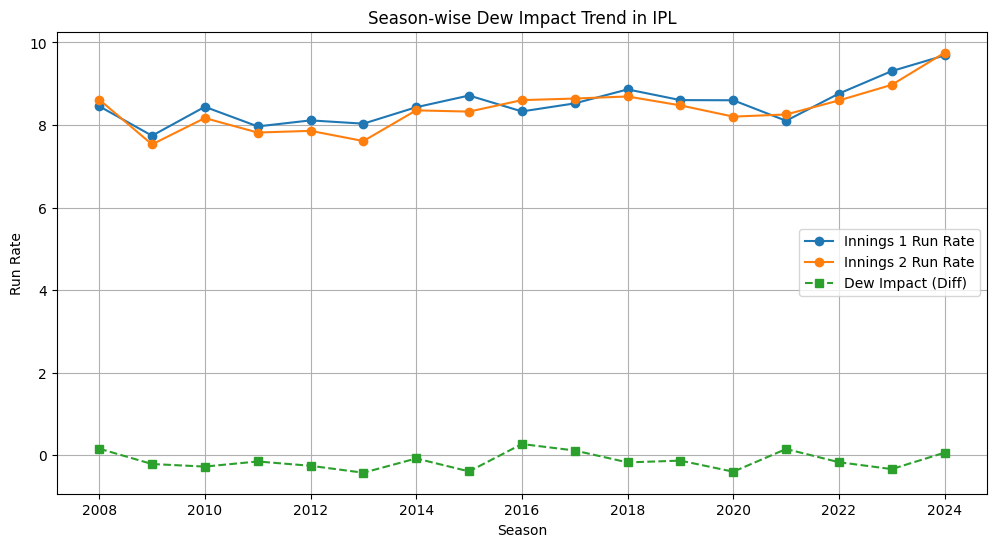

In [ ]:
# Step 13: Season-wise Dew Impact Trend

# Join matches dataset with deliveries to get season info
d_with_season = d.join(matches.select("id", "season"), d.match_id == matches.id, "left")

season_dew = (
    d_with_season.groupBy("season", "inning")
    .agg(F.sum("total_runs").alias("runs"),
         F.sum("legal_ball").alias("balls"))
    .filter(F.col("balls") > 0)
    .withColumn("run_rate", (F.col("runs") * 6.0) / F.col("balls"))
)

# Pivot by inning (1st vs 2nd)
season_dew_pivot = (
    season_dew.groupBy("season")
    .pivot("inning", [1,2])
    .agg(F.avg("run_rate"))
    .withColumnRenamed("1", "rr_inn1")
    .withColumnRenamed("2", "rr_inn2")
    .withColumn("dew_impact", F.col("rr_inn2") - F.col("rr_inn1"))
    .orderBy("season")
)

season_dew_pivot.show(20, truncate=False)

# ---- Visualization ----
import matplotlib.pyplot as plt

pdf = season_dew_pivot.toPandas()

plt.figure(figsize=(12,6))
plt.plot(pdf["season"], pdf["rr_inn1"], marker="o", label="Innings 1 Run Rate")
plt.plot(pdf["season"], pdf["rr_inn2"], marker="o", label="Innings 2 Run Rate")
plt.plot(pdf["season"], pdf["dew_impact"], marker="s", linestyle="--", label="Dew Impact (Diff)")

plt.xlabel("Season")
plt.ylabel("Run Rate")
plt.title("Season-wise Dew Impact Trend in IPL")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-148718206.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=team_dew_pd.sort_values("dew_impact", ascending=False).head(10),
/tmp/ipython-input-148718206.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=venue_dew_pd.sort_values("dew_impact", ascending=False).head(10),


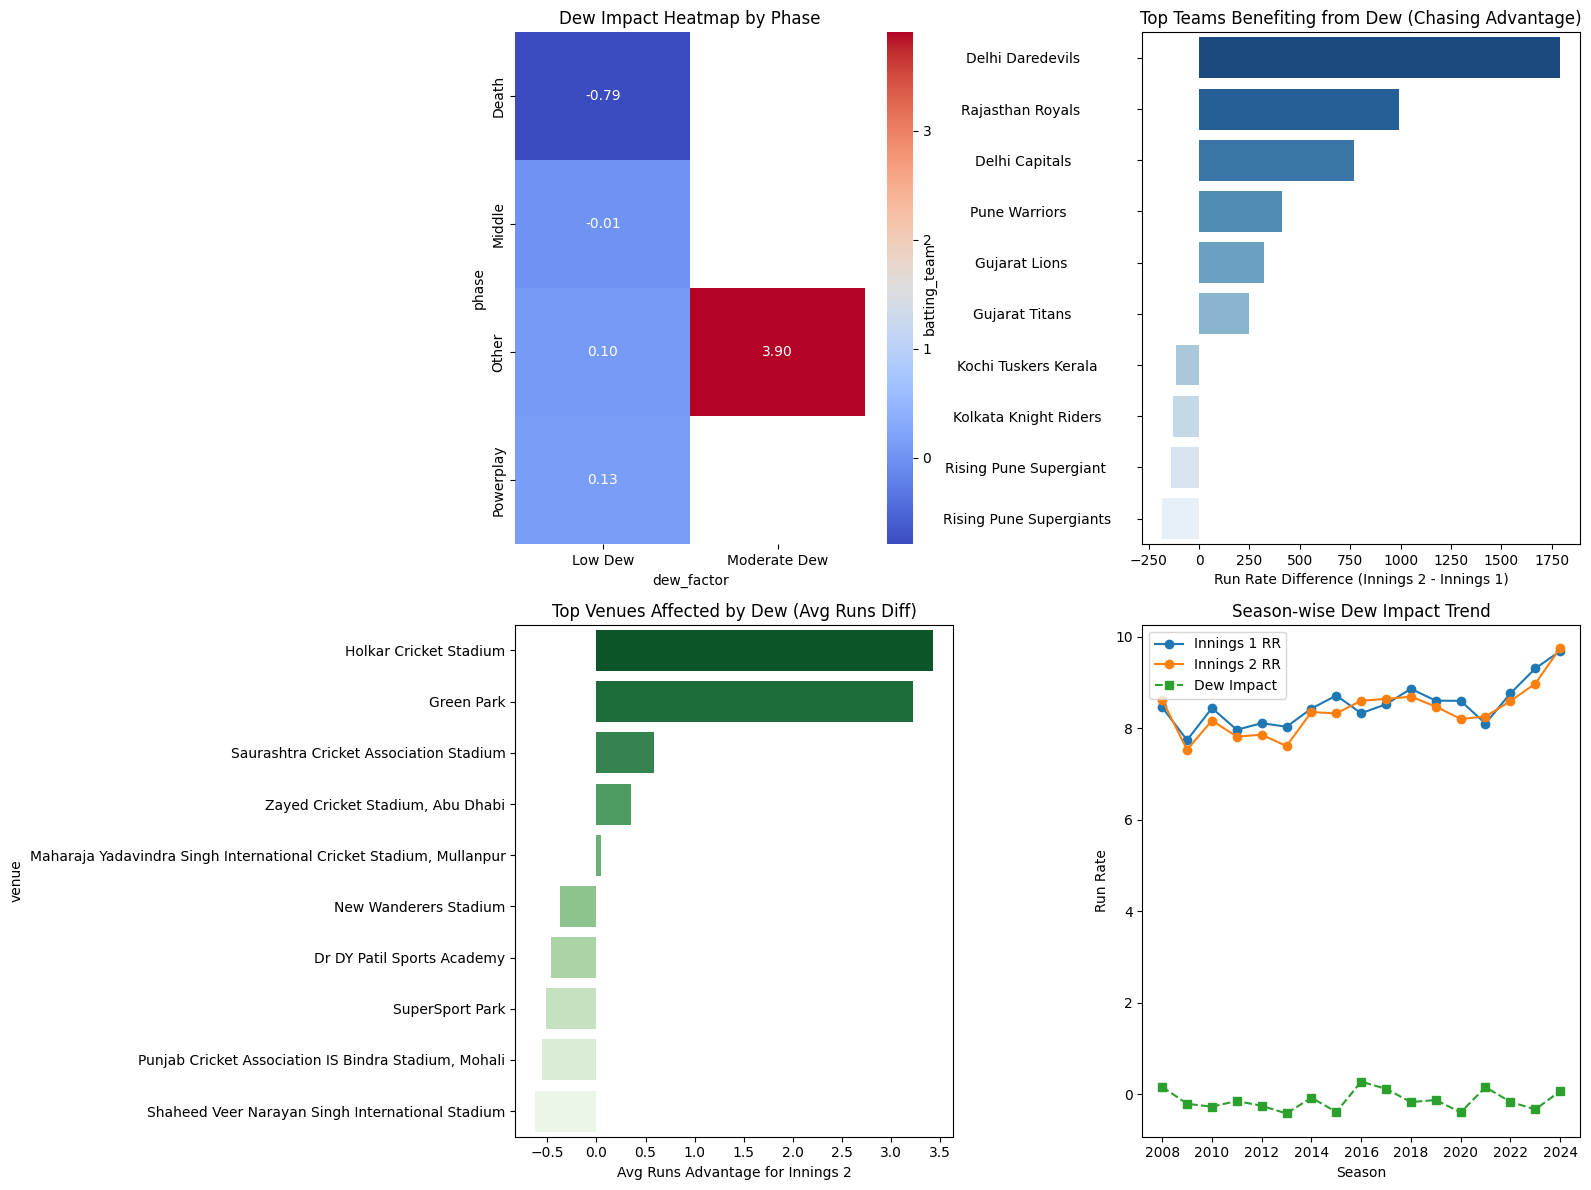

In [ ]:
# Step 14: Visualization Dashboard (multiple plots)

import matplotlib.pyplot as plt
import seaborn as sns

# Convert necessary Spark DataFrames to Pandas
dew_bins_pd = dew_bins.toPandas()
team_dew_pd = team_dew_pivot.toPandas()
venue_dew_pd = venue_dew.toPandas()
season_dew_pd = season_dew_pivot.toPandas()

plt.figure(figsize=(16,12))

# --- Plot 1: Dew Factor Heatmap (Phase vs Dew Factor bins)
plt.subplot(2,2,1)
pivot_table = dew_bins_pd.pivot(index="phase", columns="dew_factor", values="avg_diff")
sns.heatmap(pivot_table, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Dew Impact Heatmap by Phase")

# --- Plot 2: Team-wise Dew Impact
plt.subplot(2,2,2)
sns.barplot(data=team_dew_pd.sort_values("dew_impact", ascending=False).head(10),
            x="dew_impact", y="batting_team", palette="Blues_r")
plt.title("Top Teams Benefiting from Dew (Chasing Advantage)")
plt.xlabel("Run Rate Difference (Innings 2 - Innings 1)")

# --- Plot 3: Venue-wise Dew Impact
plt.subplot(2,2,3)
sns.barplot(data=venue_dew_pd.sort_values("dew_impact", ascending=False).head(10),
            x="dew_impact", y="venue", palette="Greens_r")
plt.title("Top Venues Affected by Dew (Avg Runs Diff)")
plt.xlabel("Avg Runs Advantage for Innings 2")

# --- Plot 4: Season-wise Trend
plt.subplot(2,2,4)
plt.plot(season_dew_pd["season"], season_dew_pd["rr_inn1"], marker="o", label="Innings 1 RR")
plt.plot(season_dew_pd["season"], season_dew_pd["rr_inn2"], marker="o", label="Innings 2 RR")
plt.plot(season_dew_pd["season"], season_dew_pd["dew_impact"], marker="s", linestyle="--", label="Dew Impact")
plt.title("Season-wise Dew Impact Trend")
plt.xlabel("Season")
plt.ylabel("Run Rate")
plt.legend()

plt.tight_layout()
plt.show()
